# 🛣️ Network Analysis with Python: Centrality, Clustering and Isochrones

In [25]:
# imports
import osmnx as ox
import networkx as nx
import geopandas as gpd
from pyproj import Transformer

# visualization
from keplergl import KeplerGl
from IPython.display import IFrame
import matplotlib.pyplot as plt

In [3]:
MAIN_CRS = 'EPSG:32633'
WORLD_CRS = 'EPSG:4326'
FOLIUM_CRS = 'EPSG:3857'

## 1. 🕸️ **Collect street networks data** of a city using OSMnx

In [4]:
place = "Graz, Austria"

In [5]:
# get the graph and reproject it
def get_graph_network(place, type, crs=MAIN_CRS):
    graph = ox.graph_from_place(place, network_type=type, simplify= True)
    graph = ox.project_graph(graph, to_crs=crs)
    ox.plot_graph(graph, node_size=0, bgcolor= "#040615", edge_color='#f1f1f1')
    return graph

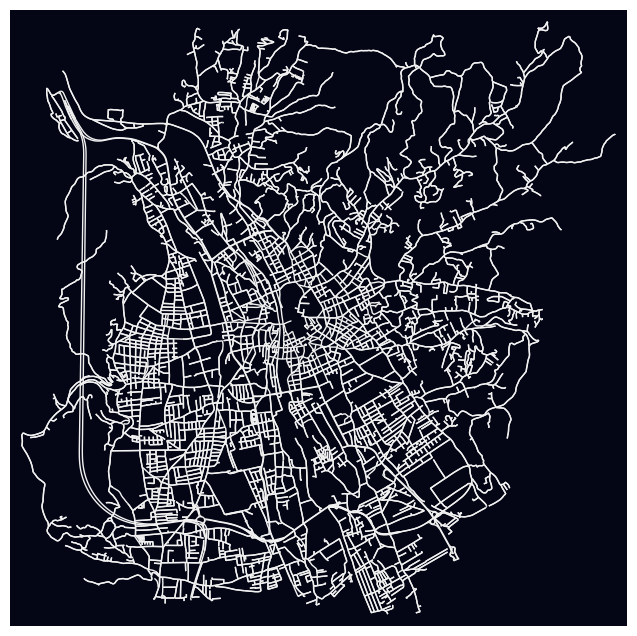

In [6]:
G_drive = get_graph_network(place, 'drive')

## 2. 📌 Centrality Analysis

##### 2.a. 🥵 Degree of centrality

In [7]:
# compute the centrality of the nodes
nodes_centrality = nx.degree_centrality(G_drive)

# add centrality to the nodes
nx.set_node_attributes(G_drive, nodes_centrality, 'centrality')

In [8]:
# set a more relevant color map
plt.set_cmap('YlOrRd')

# scaling for the centrality values 
SIZE_SCALE = 25000

# centrality value list 
centralities = nx.get_node_attributes(G_drive,'centrality').values()

# plot the graph
ox.plot_graph(G_drive,
    # use scaled value of the centrality as node size
    ## instead a scaling value (val * SCALE), you can normalize the values val-xmin / xmax-xmin
    node_size=[SIZE_SCALE * val for val in centralities], 
    # use the centrality as color
    node_color=centralities,
    bgcolor= "#040615", edge_color='#f1f1f1'
)


<Figure size 640x480 with 0 Axes>

(<Figure size 800x800 with 1 Axes>, <Axes: >)

##### 2.b. ↔️ Betweenness centrality

In [11]:
betweenness_centrality = nx.betweenness_centrality(G_drive, weight='length')

# add betweenness to the nodes
nx.set_node_attributes(G_drive, betweenness_centrality, 'betweenness')

In [12]:
# set a more relevant color map for the background
plt.set_cmap('YlOrRd')

# scaling for the betweenness values 
SIZE_SCALE = 1000

# centrality value list 
betweenness = nx.get_node_attributes(G_drive,'betweenness').values()

# plot the graph
ox.plot_graph(G_drive,
    # You can use the normalize value of the betweenness as size
    # ##[50*((val - min(betweenness)) ) / (max(betweenness) - min(betweenness)) ) for val in betweenness],   
    node_size=[val * SIZE_SCALE for val in betweenness],
    # use the centrality as color
    node_color=nx.get_node_attributes(G_drive,'betweenness').values(),
    bgcolor= "#040615", edge_color='#f1f1f1'
)

<Figure size 640x480 with 0 Axes>

(<Figure size 800x800 with 1 Axes>, <Axes: >)

##### 2.c. 🔬 Let's explore the graph interactively

In [ ]:
# export the graph to gdfs
nodes, edges = ox.graph_to_gdfs(G_drive)
# Avoid to have an additional point layer in kepler
nodes = nodes.drop(columns=['lat', 'lon', 'y', 'x'])

# create an interactive map with Kepler
kepler_map = KeplerGl()
# center the map on the data
kepler_map.config['mapState'] = {
            'latitude': nodes.iloc[0].geometry.centroid.y,
            'longitude': nodes.iloc[0].geometry.centroid.x,
            'zoom': 10
}

# Add data to the map
kepler_map.add_data(data= nodes, name='nodes')
kepler_map.add_data(data= edges, name='edges')

# save to html
kepler_map.save_to_html(file_name='explore_map.html', config=kepler_map.config)

# Visualize the map in a div
IFrame(src='./explore_map.html', width=800, height=800)

##### 2.d. 🥊 Challenge: Evolution of the network

In [14]:
# delete the 10 most central nodes and see the impact on shortest paths

# library that facilitate the identification of the highest values in a dictionary
import heapq

top_10_nodes = heapq.nlargest(10, betweenness_centrality, key=betweenness_centrality.get)
print("Top 10 nodes with highest betweenness centrality:", top_10_nodes)

# create a new graph without the top 10 nodes, but with the same node ids
G_reduced = G_drive.copy()
G_reduced.remove_nodes_from(top_10_nodes)

Top 10 nodes with highest betweenness centrality: [2048722320, 26790270, 20911145, 20929491, 21424332, 5581023893, 5581023892, 21992919, 249322893, 21525940]


In [15]:
# get 2 random nodes (see last week exercise)
orig = ox.utils_geo.sample_points(G_drive, 1).index[0][0]
dest = ox.utils_geo.sample_points(G_drive, 1).index[0][0]

/var/folders/c2/gw080m_57t3d7s43kxt9lyjc0000gn/T/ipykernel_61964/698032583.py:2: UserWarning: graph should be undirected to avoid oversampling bidirectional edges
  orig = ox.utils_geo.sample_points(G_drive, 1).index[0][0]
/var/folders/c2/gw080m_57t3d7s43kxt9lyjc0000gn/T/ipykernel_61964/698032583.py:3: UserWarning: graph should be undirected to avoid oversampling bidirectional edges
  dest = ox.utils_geo.sample_points(G_drive, 1).index[0][0]


In [16]:
# print route within the original graph
route = nx.dijkstra_path(G_drive, source=orig, target=dest, weight='length')
fig, ax = ox.plot_graph_route(G_drive, route, node_size=0, route_alpha=1, orig_dest_size=50, edge_color='#f1f1f1', route_color='darkred', route_linewidth=3, **{'node_color':'r', 'bgcolor':"#040615"} )

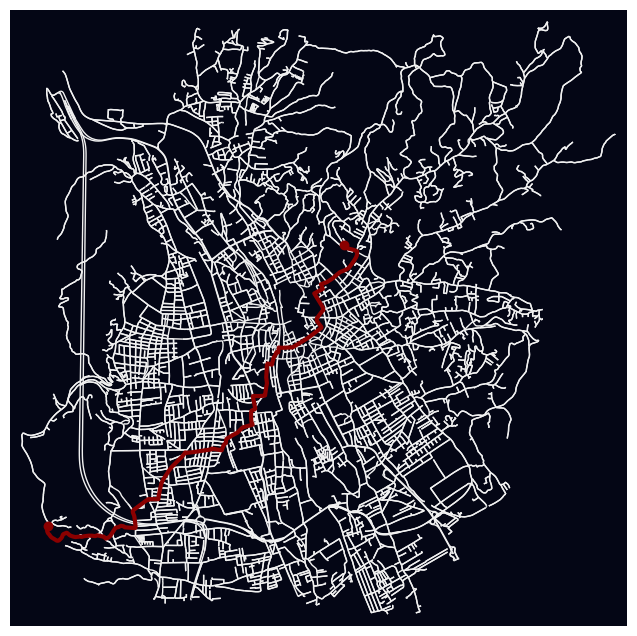

In [278]:
# print route within the reduced graph
route = nx.dijkstra_path(G_reduced, source=orig, target=dest, weight='length')
fig, ax = ox.plot_graph_route(G_reduced, route, node_size=0, route_alpha=1, orig_dest_size=50, edge_color='#f1f1f1', route_color='darkred', route_linewidth=3, **{'node_color':'r', 'bgcolor':"#040615"} )

## 3. 🍱 Network Clustering

##### 3.a. 🏘️ Create clusters based on the network

In [17]:
# python-louvain is a community extension for networkx that allows to detect communities in a graph very useful for social network analysis, but also for other types of networks
#%pip install python-louvain -q

# Import community detection algorithm
import community as community_louvain


In [18]:
# convert the graph to undirected for clustering
G_undirected = G_drive.to_undirected()

# compute the best partition using the Louvain method
partition = community_louvain.best_partition(G_undirected)

# assign cluster labels as node attributes
nx.set_node_attributes(G_undirected, partition, 'cluster')

##### 3.b. 👀 Plotting of the results

<Figure size 640x480 with 0 Axes>

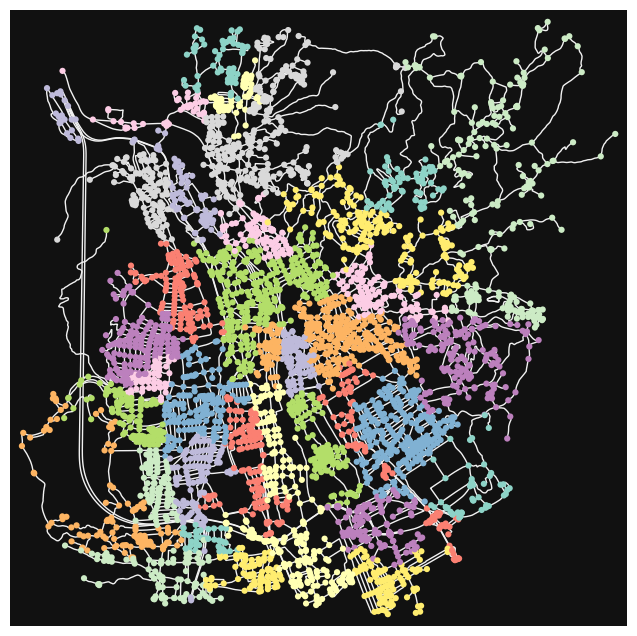

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [19]:
# set a more relevant color map
plt.set_cmap('Set3')

# cluster value list
clusters = nx.get_node_attributes(G_undirected, 'cluster').values()

# plot the network with nodes colored by cluster value
ox.plot_graph(
    G_undirected,
    node_color=partition.values(),
    node_size=20,
    edge_color='#f1f1f1'
)

##### 3.c. 😎 Interactive Visualization

In [ ]:
nodes, edges = ox.graph_to_gdfs(G_undirected)

nodes.explore(column='cluster', categorical=True, marker_kwds={'radius':5}, style_kwds={'fillOpacity': 1})

##### 3.d. 🥊 Challenges: are these cluster matching the city boundaries

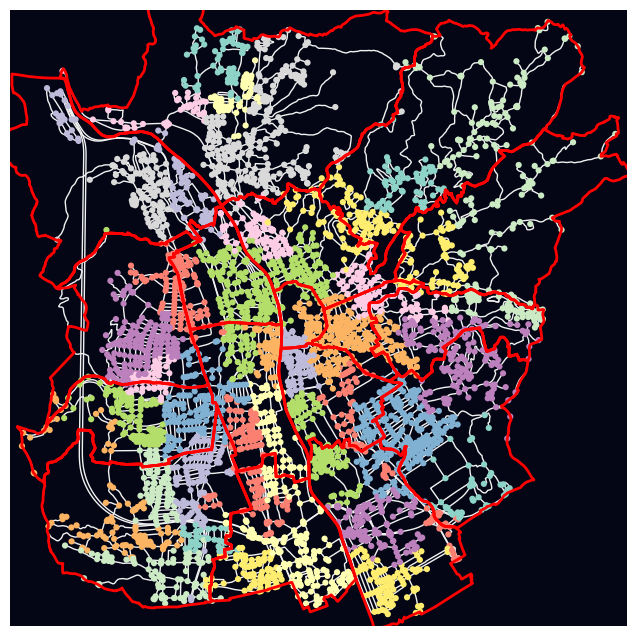

In [21]:
# let's add the city districts 

# get the city districts
districts = ox.features_from_place('Graz, austria', {'admin_level': '9', 'boundary_type': 'administrative'})
districts = districts.to_crs(ox.project_graph(G_drive).graph['crs'])

fig, ax = ox.plot_graph(
    G_undirected,
    node_color=clusters,
    node_size=20,
    edge_color='#f1f1f1',
    bgcolor= "#040615",
    show=False , # Don't show the plot yet
)

districts.plot(ax=ax, facecolor="none", edgecolor='red', linewidth=2)

plt.show()

## 4. 🚶🏻 15-minutes city

##### 4.a. 🏗️ Initialization

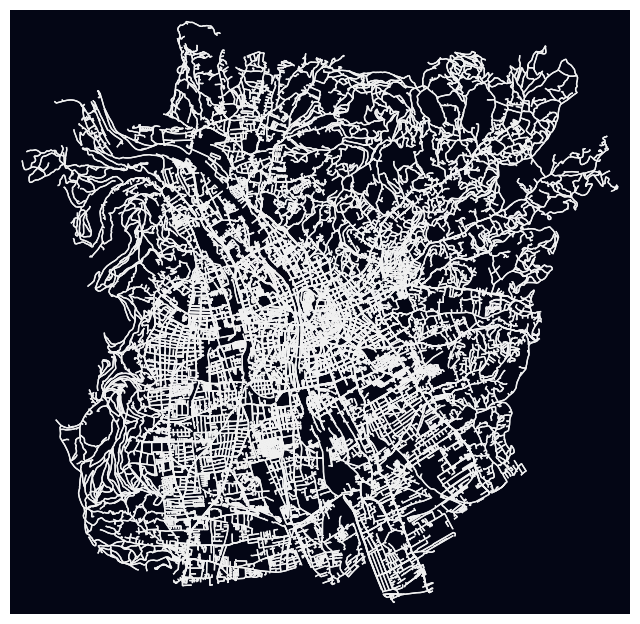

In [22]:
# Get the netowrk of Graz
G_walk = get_graph_network(place, 'walk')
G_walk = G_walk.to_undirected()

In [23]:
# crs transformation function
def to_crs(x, y, target_crs, source_crs):
    transformer = Transformer.from_crs(source_crs, target_crs)
    return transformer.transform(x, y)

In [26]:
# Get address coordinates and nearest node

address = "Heinrichstrasse 36, 8010 Graz"

# geocode & reproject the address
adress_coord = gpd.tools.geocode(  
        [address]
    ).geometry
x_4326 = adress_coord[0].y
y_4326 = adress_coord[0].x
x_32633, y_32633 = to_crs(x_4326, y_4326, MAIN_CRS, WORLD_CRS)

print(f"coordinates of the source {x_32633, y_32633}")

# get the nearest node

nodes, distance = ox.nearest_nodes(G_walk, X=[x_32633], Y=[y_32633], return_dist=True)

# get the nearest node to the source, select the first element of the list
node = nodes[0]

print(f"node selected for source is {node}, with a distance of {round(distance[0],1)} meters")

coordinates of the source (534072.1208797126, 5214045.149401939)
node selected for source is 1474253833, with a distance of 11.7 meters


##### 4.b. ⏳ Calculate isochrones from a point

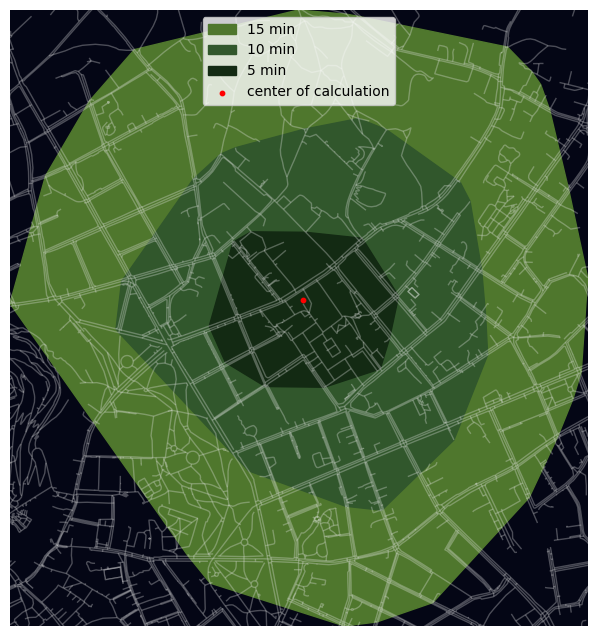

In [27]:
walking_speed = 4.5 # km/h
walking_speed_m = walking_speed * 1000 / 60 # m/min

# add the travel time to the edges
for _, _, data in G_walk.edges(data=True):
    data['time'] = data['length'] / walking_speed_m

# create a subgraph container
fig, ax = plt.subplots(figsize=(12, 8))

# define travel times and colors for isochrones
travel_times = [5, 10, 15] # in minutes
colors = [ '#4f772d','#31572c','#132a13'] # colors for the isochrones
for time, color in zip(sorted(travel_times, reverse=True), colors): # reverse the list to start with the largest time
    # create a subgraph with nodes within the travel time
    subgraph = nx.ego_graph(G_walk, node, radius=time, distance='time')
    
    # get all nodes in the subgraph
    nodes, _ = ox.graph_to_gdfs(subgraph)
    
    # create a polygon from the convex hull of the nodes
    polygon = nodes.unary_union.convex_hull

    # add the polygon to the plot
    ax.fill(*polygon.exterior.xy # use a splat operator to unpack the x and y coordinates from the polygon
            , color=color
            , alpha=1
            , label=f"{time} min")
    
    # get the biggest polygon to calculate the extent of the plot
    if time == max(travel_times):
        # get the bounds of the biggest polygon
        bounds = polygon.bounds
        margin = 0.001

# add the network
ox.plot_graph(G_walk, ax=ax, node_size=0, edge_color='#f1f1f1', edge_linewidth=1, edge_alpha= .3, show=False, close=False)

# add the source point
ax.scatter(x_32633, y_32633, c='r', s=10, zorder=5, label='center of calculation')

ax.set_xlim([bounds[0] - margin, bounds[2] + margin])
ax.set_ylim([bounds[1] - margin, bounds[3] + margin])

ax.set_facecolor('#040615')

ax.legend()